In [1]:
import pandas as pd

#printing settings, prints all rows and columns

'''
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
'''

"\npd.set_option('display.max_rows', None)\npd.set_option('display.max_columns', None)\npd.set_option('display.width', None)\npd.set_option('display.max_colwidth', None)\n"

Read shapefiles

In [2]:
import geopandas as gpd

# River channel centerline
centerline = gpd.read_file(r'C:\Users\oonao\Documents\lipasto\5_vuosi\gradu\gis\oulankajoki.shp')

#print(centerline)

# Feasible region
feasible_region = gpd.read_file(r'C:\Users\oonao\Documents\lipasto\5_vuosi\gradu\gis\sallittualue_maalajit2.shp')

#print(feasible_region)

Plotting river channel, feasible region and coordinates.

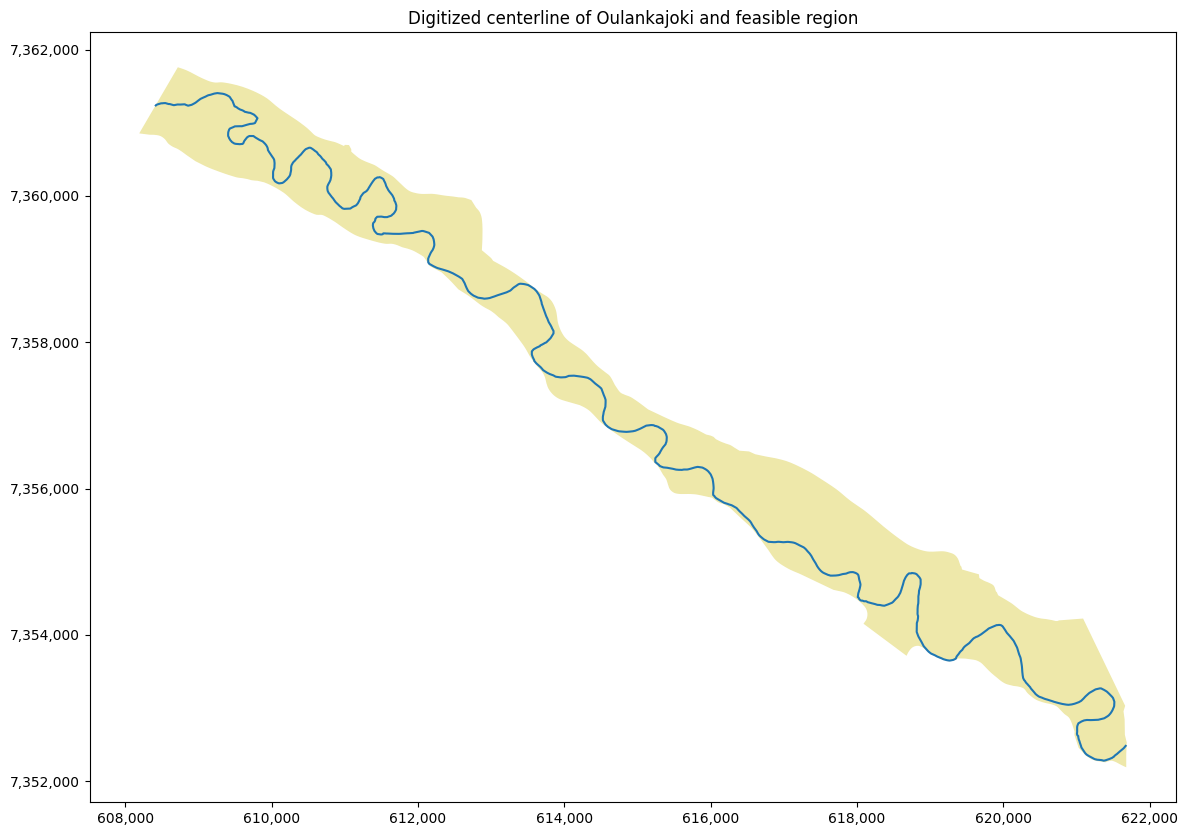

In [3]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Plot

fig, ax = plt.subplots(figsize=(15, 10))

# x and y axis
def format_eastings(value, pos):
    return f'{int(value):,}'

def format_northings(value, pos):
    return f'{int(value):,}'

ax.xaxis.set_major_formatter(FuncFormatter(format_eastings))
ax.yaxis.set_major_formatter(FuncFormatter(format_northings))

feasible_region.plot(ax=ax, color = 'palegoldenrod')

centerline.plot(ax=ax)

title_txt = "Digitized centerline of Oulankajoki and feasible region"
plt.title(title_txt)

plt.show()

Break centerline into points, and smooth with Savitzky-Golay filter

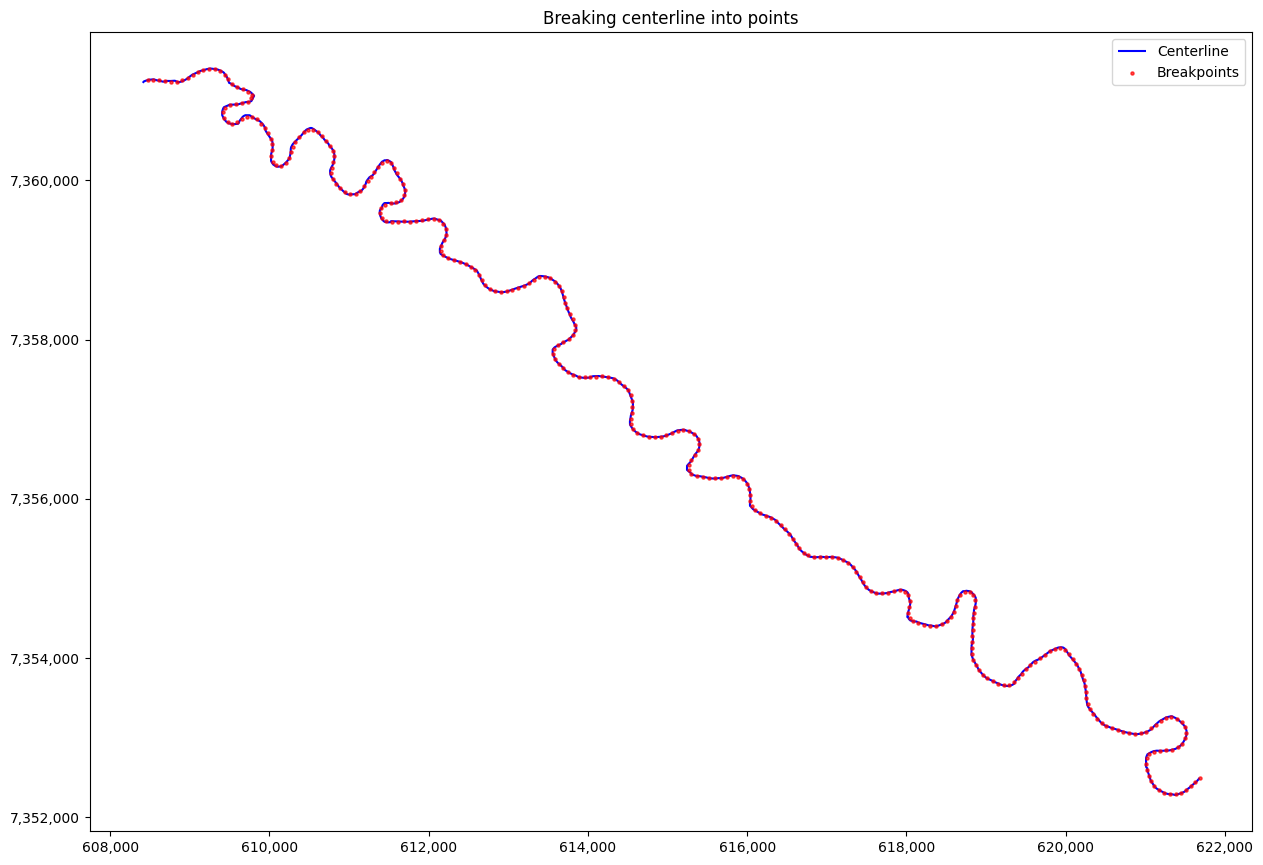

In [4]:
from shapely.geometry import LineString, Point
from scipy.signal import savgol_filter

# GeoDataFrame
points = gpd.GeoDataFrame(columns=['geometry'])

# Function to create breakpoints at given interval
def create_breakpoints(geometry, interval):

    breakpoints = LineString(geometry).interpolate(range(0, int(geometry.length), interval))

    #Smooth points using Savitzky-Golay filtering
    x_coords = [point.x for point in breakpoints]
    y_coords = [point.y for point in breakpoints]
    smoothed_x = savgol_filter(x_coords, window_length = 7, polyorder=3) 
    smoothed_y = savgol_filter(y_coords, window_length = 7, polyorder=3)
    
    smoothed_breakpoints = [Point(x, y) for x, y in zip(smoothed_x, smoothed_y)]

    # Add points to gdf
    point = gpd.GeoDataFrame(geometry=smoothed_breakpoints, crs='EPSG:3067')
    return point[::-1] 


# Divide points
points = create_breakpoints(centerline['geometry'].iloc[0], 75)


# Plot 
fig, ax = plt.subplots(figsize=(15, 15))
def format_eastings(value, pos):
    return f'{int(value):,}'

def format_northings(value, pos):
    return f'{int(value):,}'

ax.xaxis.set_major_formatter(FuncFormatter(format_eastings))
ax.yaxis.set_major_formatter(FuncFormatter(format_northings))

centerline.plot(ax=ax, color = 'blue', zorder = 1, linewidth = 1.5, label = 'Centerline')

points.plot(ax=ax, color='red', marker='o', markersize=5, alpha = 0.7, label = 'Breakpoints') 

title_txt = "Breaking centerline into points"
plt.title(title_txt)

ax.legend()

plt.show()


Spline curve to connect points back into a continuous line

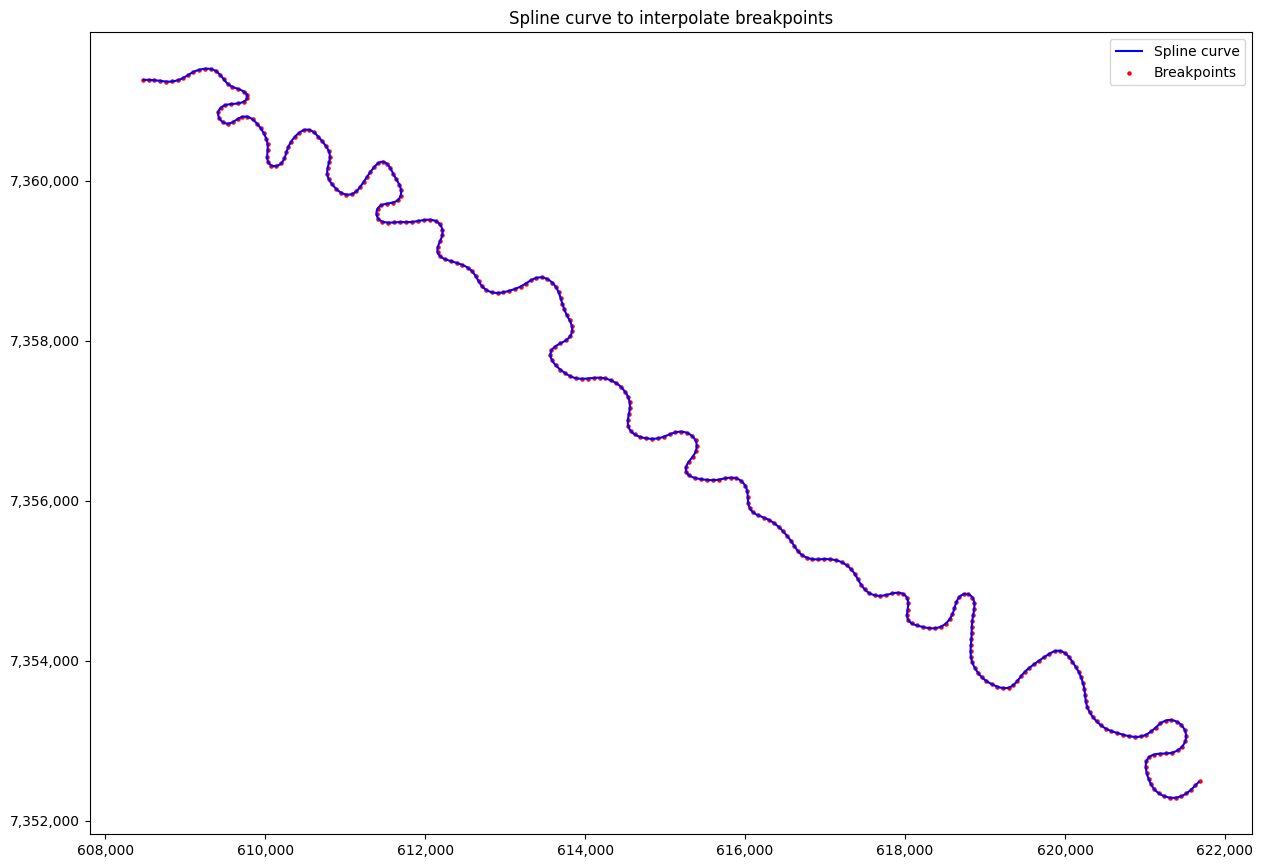

In [5]:
import geopandas as gpd
import numpy as np
from scipy.interpolate import splprep, splev
from shapely.geometry import LineString, Point
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def create_spline(points):
    x, y = zip(*points)

    # Spline parameters
    tck, u = splprep([x, y], s=3)  
    t_new = np.linspace(0, 1, 1000)
    spline_points = splev(t_new, tck)
    
    # Convert to Points
    spline_points = [Point(coord) for coord in zip(spline_points[0], spline_points[1])]
    bspline = LineString(spline_points)
    bspline_gdf = gpd.GeoDataFrame(geometry=[bspline])

    return bspline, bspline_gdf

# Generate spline curve
spline_ls, spline_gdf = create_spline(points['geometry'].apply(lambda point: (point.x, point.y)).tolist())

# Plot
fig, ax = plt.subplots(figsize=(15, 12))

def format_eastings(value, pos):
    return f'{int(value):,}'

def format_northings(value, pos):
    return f'{int(value):,}'

ax.xaxis.set_major_formatter(FuncFormatter(format_eastings))
ax.yaxis.set_major_formatter(FuncFormatter(format_northings))

spline_gdf.plot(ax=ax, color='blue', label = 'Spline curve')

points.plot(ax=ax, color='red', marker='o', markersize=5, label = 'Breakpoints')

title_txt = "Spline curve to interpolate breakpoints"
plt.title(title_txt)

ax.legend()
plt.show()

Finding inflectionpoints that separate meander bends by f(xi)=(x_{i-1} - x_i)*(x_i - x_{i+1})T

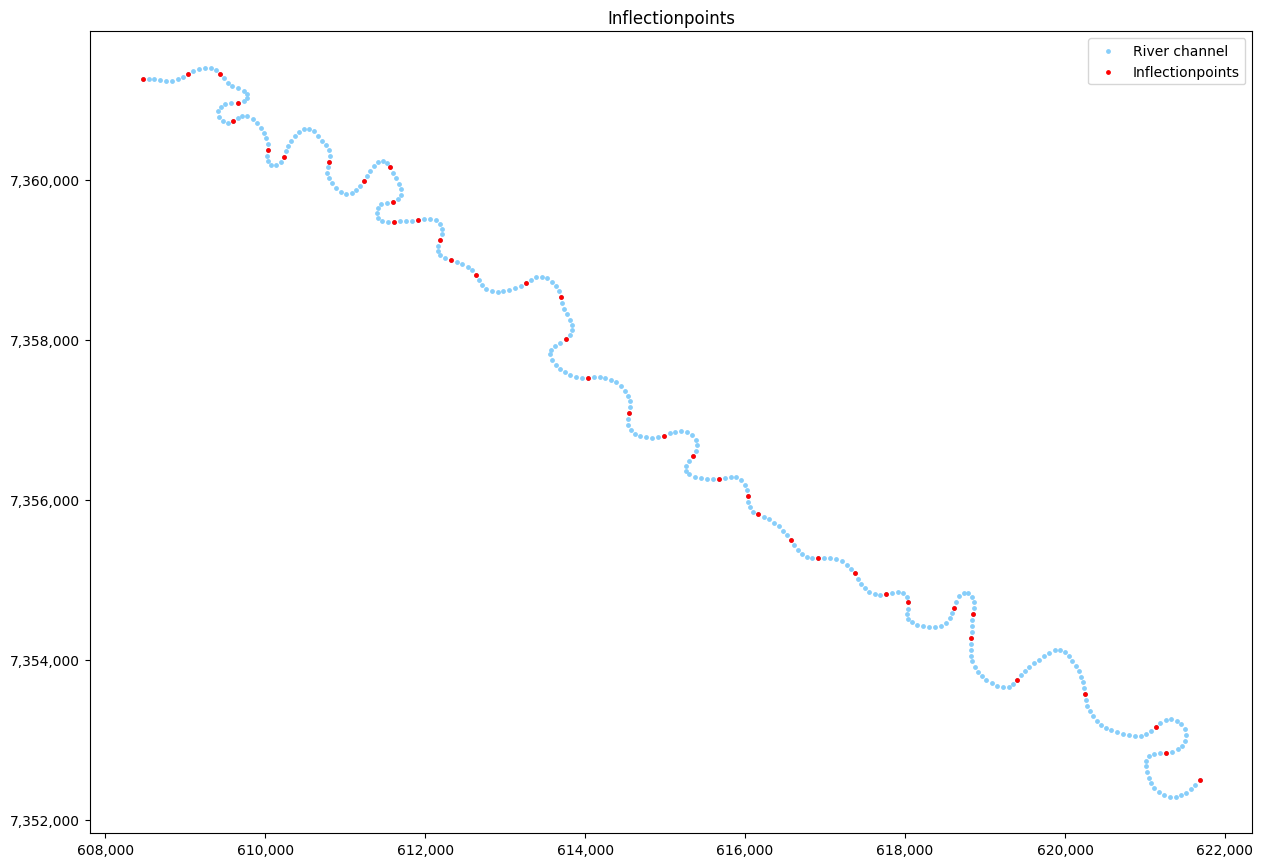

In [6]:
#Inflectionpoints defined by f(xi)=(x_{i-1} - x_i)*(x_i - x_{i+1})T 

import numpy as np
from numpy import linalg

def define_inflectionpoints(points, p_between):
    inflectionpoint_list = []
    points_in_between=0
    inflectionpoint_list.append(points.iloc[0]) # first

    for i in range(1, len(points)-2):
        #vectors
        v1 = (np.array(points.iloc[i-1].coords[0])) - (np.array(points.iloc[i].coords[0]))

        v2 = (np.array(points.iloc[i].coords[0])) - (np.array(points.iloc[i+1].coords[0]))
        v2_orto = np.array([-v2[1], v2[0]])
        
        v3 = (np.array(points.iloc[i+1].coords[0])) - (np.array(points.iloc[i+2].coords[0]))
        v3_orto = np.array([-v3[1], v3[0]])
        # dot product
        dot_product1 = np.dot(v1, v2_orto)
        dot_product2 = np.dot(v2, v3_orto)

        #counter
        points_in_between = points_in_between + 1

        # Check when sign changes
        if np.sign(dot_product1) != np.sign(dot_product2)  and points_in_between > p_between:
            inflectionpoint_list.append(points.iloc[i]) # add to inflectionpoint list
            
            points_in_between = 0
    inflectionpoint_list.append(points.iloc[len(points)-1]) # last
    
    return inflectionpoint_list

inflection_points = define_inflectionpoints(points['geometry'], 3)

# Plot
fig, ax = plt.subplots(figsize=(15, 12))

def format_eastings(value, pos):
    return f'{int(value):,}'

def format_northings(value, pos):
    return f'{int(value):,}'

ax.xaxis.set_major_formatter(FuncFormatter(format_eastings))
ax.yaxis.set_major_formatter(FuncFormatter(format_northings))

#ax.tick_params(axis='both', which='major', labelsize=11)

points.plot(ax=ax, color='lightskyblue', marker='o', markersize=6, label='River channel')

gpd.GeoDataFrame(geometry=inflection_points).plot(ax=ax, color='red', marker='o', markersize=6, label='Inflectionpoints')

title_txt = "Inflectionpoints"
plt.title(title_txt)

ax.legend()
plt.show()


Define meander bend ID's 'meander'

In [7]:
# Define bends

def define_meander(points, inflectionpoints):
    points['meander'] = None
    meander_id = 0
    j = 1

    for i in range(len(points['geometry'])):
        if points['geometry'].iloc[i].coords[0] == inflectionpoints[j].coords[0]:
            points.at[len(points) - i - 1, 'meander'] = meander_id
            meander_id += 1
            if j != len(inflectionpoints) - 1:
                j += 1
        else:
            points.at[len(points) - i - 1, 'meander'] = meander_id

define_meander(points, inflection_points)

print(points)

                           geometry meander
337  POINT (608469.424 7361261.115)       0
336  POINT (608542.494 7361261.159)       0
335  POINT (608615.932 7361256.265)       0
334  POINT (608689.479 7361249.369)       0
333  POINT (608763.416 7361240.210)       0
..                              ...     ...
4    POINT (621451.608 7352306.115)      37
3    POINT (621516.763 7352340.572)      37
2    POINT (621576.058 7352388.657)      37
1    POINT (621630.801 7352441.681)      37
0    POINT (621681.354 7352493.189)      37

[338 rows x 2 columns]


Top points.

Max distance from midpoint of line defined between inflection points

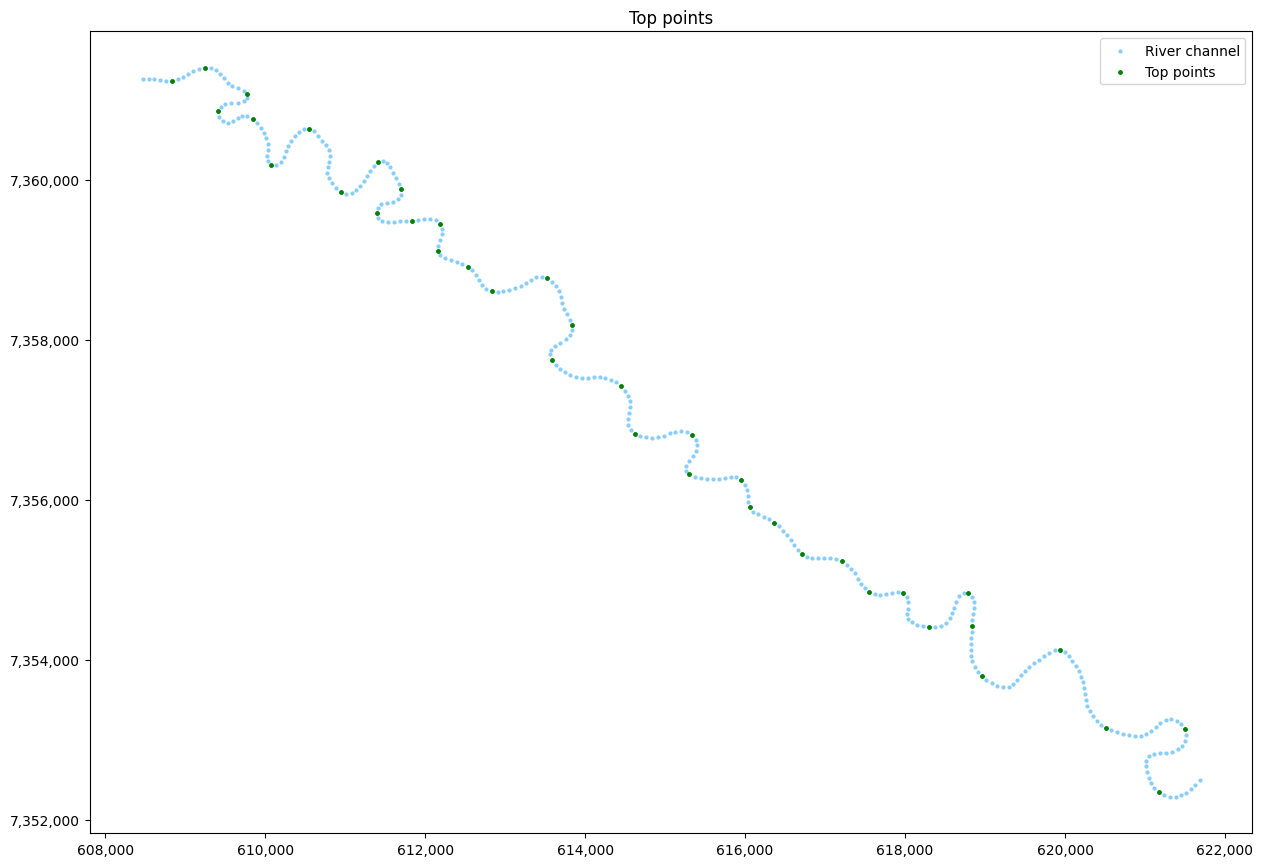

In [8]:
import numpy as np
from shapely.geometry import Point, LineString

def define_top_points(inflection_points, points):
    farthest_points = [] 
    max_distance = 0
    
    for i in range(len(inflection_points) - 1):
        p1 = inflection_points[i]
        p2 = inflection_points[i + 1]
        
        line = LineString([p1, p2])
        
        meander_points = points[points['meander'] == i]
        
        dist = []
        
        # Calculate distances of all points from line
        for j in range(len(meander_points)):
            distance = line.distance(meander_points['geometry'].iloc[j])
            dist.append(distance)
        
        max_distance = max(dist)  # Find max distance point
        farthest_point_index = dist.index(max_distance)  
        farthest_point = meander_points['geometry'].iloc[farthest_point_index]  
        
        farthest_points.append(farthest_point) 
        
    return farthest_points

top = define_top_points(inflection_points, points)

# Plot
fig, ax = plt.subplots(figsize=(15, 12))

def format_eastings(value, pos):
    return f'{int(value):,}'

def format_northings(value, pos):
    return f'{int(value):,}'

ax.xaxis.set_major_formatter(FuncFormatter(format_eastings))
ax.yaxis.set_major_formatter(FuncFormatter(format_northings))

points.plot(ax=ax, color='lightskyblue', marker='o', markersize=4, label= 'River channel')

gpd.GeoDataFrame(geometry=top).plot(ax=ax, color='green', marker='o', markersize=6, label='Top points')

title_txt = "Top points"
plt.title(title_txt)

ax.legend()
plt.show()

Calculate radius of circle that intersects three consecutive points.

In [9]:
import numpy as np

def radius_and_intersectionpoint(points):
    radius_list = []
    intersectionpoint_list = []

    for i in range(len(points) - 2):

        # Three consecutive points
        p1 = np.array(points['geometry'].iloc[i].coords[0])
        p2 = np.array(points['geometry'].iloc[i + 1].coords[0])
        p3 = np.array(points['geometry'].iloc[i + 2].coords[0])

        midpoint1 = 0.5 * (p1 + p2)
        normal1 = np.array([-(p2 - p1)[1], (p2 - p1)[0]])

        midpoint2 = 0.5 * (p2 + p3)
        normal2 = np.array([-(p3 - p2)[1], (p3 - p2)[0]])
       
        A = np.array([[normal1[0], -normal2[0]], [normal1[1], -normal2[1]]])
        B = np.array([midpoint2[0] - midpoint1[0], midpoint2[1] - midpoint1[1]])
        
        if np.linalg.det(A) == 0:
            print("Singular matrix. Skipping this point.")
            continue
        else:
        # Solve
            solution = np.linalg.solve(A, B)

            # intersection
            intersection_points = midpoint1 + solution[1] * normal1
            intersectionpoint_list.append(intersection_points)
        
            # radius
            radius = np.linalg.norm(intersection_points - p2)
            radius_list.append(radius)

    return radius_list, intersectionpoint_list, solution, A, B 

rad, inter, sol, A, B = radius_and_intersectionpoint(points)

print("Radius:", rad)



Radius: [1084.7198792379877, 2724.542584162364, 2473.1896949573293, 533.5002021769382, 384.8413208842939, 396.363895846451, 500.1644556939617, 37059.0900641687, 469.59303420038856, 404.02583168467106, 353.66437886487046, 216.28801177659665, 203.2224678994972, 488.9055720042368, 2442.9325561302435, 281.05646735031263, 283.26670539275574, 942.7723298111478, 258.2620652130816, 89.27017065157425, 48.668608067898234, 117.37359175403299, 347.4298010885354, 819.9401861306272, 248.29576048242384, 129.46874055525524, 94.38253518662685, 115.99256143919446, 144.87751419986293, 105.62582072954663, 281.49650031129573, 573.2366660706939, 157.75508661127603, 119.19497872411489, 245.2363282697441, 586.343054652395, 658.1678358880574, 543.873033265019, 429.13384978270096, 295.86269897428235, 1012.0826085864747, 318.3743679313411, 136.41205897533857, 80.34143144126399, 101.35817303661322, 135.73156508499636, 321.4457172517039, 3235.912851512359, 549.0995074892652, 413.4072284366426, 448.1836815877932, 3

Curvature (Inverse of radius) 

Calculates curvature for each point. 

                           geometry meander  curvature
337  POINT (608469.424 7361261.115)       0        NaN
336  POINT (608542.494 7361261.159)       0   0.000922
335  POINT (608615.932 7361256.265)       0   0.000367
334  POINT (608689.479 7361249.369)       0   0.000404
333  POINT (608763.416 7361240.210)       0   0.001874
..                              ...     ...        ...
4    POINT (621451.608 7352306.115)      37   0.003152
3    POINT (621516.763 7352340.572)      37   0.002687
2    POINT (621576.058 7352388.657)      37   0.001152
1    POINT (621630.801 7352441.681)      37        NaN
0    POINT (621681.354 7352493.189)      37        NaN

[338 rows x 3 columns]


C:\Users\oonao\AppData\Local\Temp\ipykernel_16424\3526449029.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


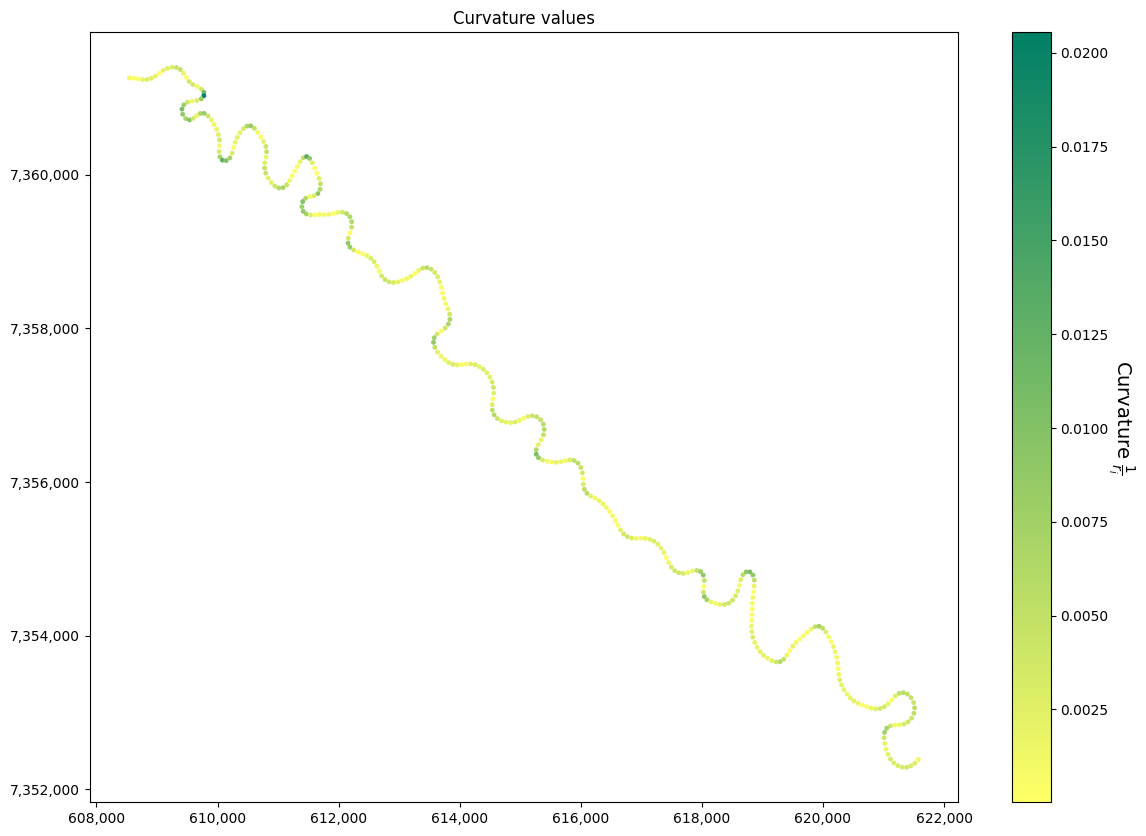

In [10]:
#Curvature 1/R

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def calculate_curvature(points, radius):
    curvature_list = []
    shifted_radius = [np.nan] + radius[:-1]

    points['curvature'] = np.nan

    for i in range(len(points) - 2):
        radius = shifted_radius[i]
        curvature = 1 / radius
        curvature_list.append(curvature)

    points['curvature'][:-2] = curvature_list 

calculate_curvature(points, rad)

print(points)

# Plot
fig, ax = plt.subplots(figsize=(14, 10))
scatter = ax.scatter(
    points.geometry.x,
    points.geometry.y,
    c=points['curvature'],
    cmap= 'summer_r',
    s=6
)

cbar = plt.colorbar(scatter, label='Curvature')
cbar.set_label(r'Curvature $\frac{1}{r_i}$', rotation=270, labelpad=20, fontsize = 14)

def format_eastings(value, pos):
    return f'{int(value):,}'

def format_northings(value, pos):
    return f'{int(value):,}'

ax.xaxis.set_major_formatter(FuncFormatter(format_eastings))
ax.yaxis.set_major_formatter(FuncFormatter(format_northings))

#ax.tick_params(axis='both', which='major', labelsize=12)

title_txt = "Curvature values"
plt.title(title_txt)

plt.show()


Normalized curvature.

curvature_ij / max curvature of meander_j

                           geometry meander  curvature norm_curvature
337  POINT (608469.424 7361261.115)       0        NaN            NaN
336  POINT (608542.494 7361261.159)       0   0.000922       0.354784
335  POINT (608615.932 7361256.265)       0   0.000367        0.14125
334  POINT (608689.479 7361249.369)       0   0.000404       0.155605
333  POINT (608763.416 7361240.210)       0   0.001874       0.721352
..                              ...     ...        ...            ...
4    POINT (621451.608 7352306.115)      37   0.003152        0.41503
3    POINT (621516.763 7352340.572)      37   0.002687       0.353714
2    POINT (621576.058 7352388.657)      37   0.001152       0.151681
1    POINT (621630.801 7352441.681)      37        NaN            NaN
0    POINT (621681.354 7352493.189)      37        NaN            NaN

[338 rows x 4 columns]


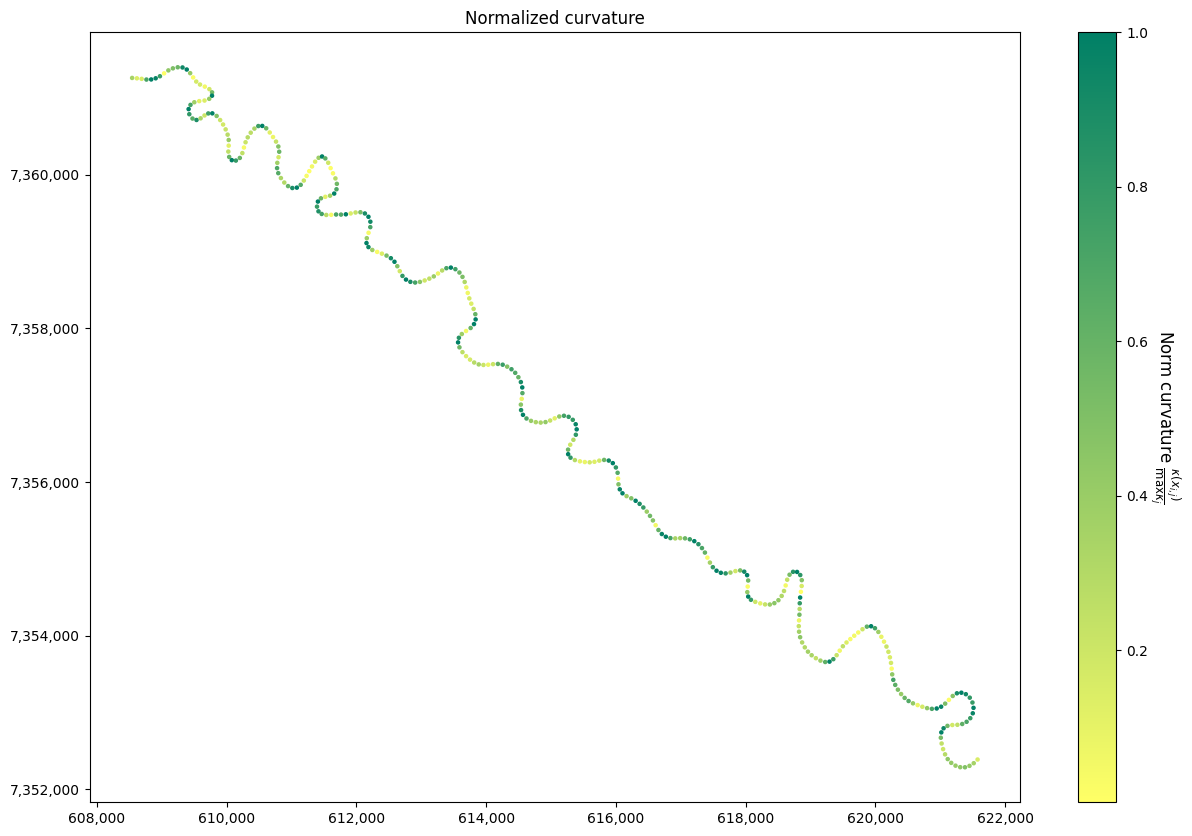

In [11]:
# Norm curvature k(x_i,j)/K_M_j


def define_normalized_curvature(points):
    points['norm_curvature'] = None

    for i in range(max(points['meander'])+1): 

            pm = (points['meander'] == i)
            filtered_pm = points[pm]

            maxcurvature = filtered_pm['curvature'].max()

            for index in filtered_pm.index:
                points.loc[index, 'norm_curvature'] = filtered_pm.loc[index, 'curvature'] / maxcurvature

define_normalized_curvature(points)

print(points)

#Plot

fig, ax = plt.subplots(figsize=(15, 10))
scatter = ax.scatter(
    points.geometry.x,
    points.geometry.y,
    c=points['norm_curvature'],
    cmap='summer_r',
    s=5
)

cbar = plt.colorbar(scatter, label='Norm curvature')
cbar.set_label(r'Norm curvature $\frac{\kappa(x_{i,j})}{\max \kappa_j}$', rotation=270, labelpad=25, fontsize = 12)

def format_eastings(value, pos):
    return f'{int(value):,}'

def format_northings(value, pos):
    return f'{int(value):,}'

ax.xaxis.set_major_formatter(FuncFormatter(format_eastings))
ax.yaxis.set_major_formatter(FuncFormatter(format_northings))

#ax.tick_params(axis='both', which='major', labelsize=11)

title_txt = "Normalized curvature"
plt.title(title_txt)

plt.show()
                  

Function that verifies whether point lies within the feasible area.

In [12]:
def check_feasible_region(edellinen, point, feasibleregion):

    if Point(point).within(feasibleregion.geometry.iloc[0]):
        new_p = Point(point)
    else:
        new_p = edellinen

    return new_p

Formation of new oxbow-lakes

In [13]:
import geopandas as gpd
import pandas as pd

def new_oxbow(points, inflection, meters):
    new_points = points.copy()
    oxbows = []

    for i in range(len(inflection) - 1):
        if inflection[i].distance(inflection[i + 1]) < meters:
            oxbow_points = new_points[new_points['meander'] == i]
            if not oxbow_points.empty:
                oxbows.append(gpd.GeoDataFrame(oxbow_points, geometry='geometry'))

            new_points = new_points[new_points['meander'] != i]

    if oxbows:
        oxbow_gdf = pd.concat(oxbows, ignore_index=True)
    else:
        oxbow_gdf = gpd.GeoDataFrame()

    return new_points, oxbow_gdf

Define directions D and L.

In [14]:
import math

def define_directions_top(inflectionpoints, toppoints):
    D_list = []
    L_top_list = []
    j = 0
    
    for i in range(len(inflectionpoints) - 1):

        # D points
        x1_inf, y1_inf = inflectionpoints[i].x, inflectionpoints[i].y
        x2_inf, y2_inf = inflectionpoints[i + 1].x, inflectionpoints[i + 1].y

        # Direction of D
        v_inf = (x2_inf - x1_inf, y2_inf - y1_inf)

        # Length of D
        v_inf_length = math.sqrt(v_inf[0] ** 2 + v_inf[1] ** 2) 

        # Norm D
        D = (v_inf[0] / v_inf_length, v_inf[1] / v_inf_length)
    
        # L points
        x_mid , y_mid  = 0.5*(x1_inf + x2_inf) , 0.5*(y1_inf + y2_inf)
        x_top, y_top = toppoints[j].x, toppoints[j].y
        j = j+1

        # Direction L
        v_top = (x_top - x_mid, y_top - y_mid)

        # Length L
        v_top_length = math.sqrt(v_top[0] ** 2 + v_top[1] ** 2)

        # Norm L
        L = (v_top[0] / v_top_length, v_top[1] / v_top_length)

        D_list.append(D)
        L_top_list.append(L)

    return D_list, L_top_list

D, L_top = define_directions_top(inflection_points, top)
print("D:",  D)
print("L:", L_top)


D: [(0.9944683330267104, 0.10503682500473686), (0.9999812269670741, 0.006127455705669588), (0.5275604178064293, -0.8495175133944596), (-0.2523624749353141, -0.9676327718946496), (0.7730764065544905, -0.6343129114473363), (0.9080230009268574, -0.418920314365136), (0.9953525611076735, -0.09629786652047546), (0.8721400044263345, -0.4892563874690173), (0.8903223945521963, 0.4553306861598977), (0.0664222514498862, -0.9977916037491638), (0.0693120540966272, -0.9975950276324087), (0.9982406754751285, 0.05929210594134007), (0.7386009235264279, -0.6741429193916583), (0.46994456001272666, -0.8826959332150822), (0.857611809388715, -0.5142975640589935), (0.9887978286914664, -0.14926102630975632), (0.9234571600099264, -0.3837015423820983), (0.12565109266773133, -0.9920744946380817), (0.4933154534333046, -0.8698504833613034), (0.7579293900587316, -0.6523365999889927), (0.8409778275382019, -0.5410695829457853), (0.8191550844474061, -0.5735720945303763), (0.7499883218504748, -0.6614510693074044), (0.8

Migration offsets OD and OL.

Accepting/Not accepting negative offsets of lateral and downstream migration

Model created by Parquer, M. N., Collon, P., & Caumon, G. (2017). Reconstruction of Channelized Systems Through a Conditioned Reverse Migration Method.

In [15]:
def offsets(points, OD, OL, sD, sL, w):
    od_xi = []
    ol_xi = []

    max_curvature=points['curvature'].max()

    for i in range(len(points)):
            
        if w > 0:
            OD_xi = OD - (sD * (points['curvature'].iloc[i] / max_curvature))

            OL_xi = OL - (sL * (1 - (points['curvature'].iloc[i] / max_curvature)))


        elif w < 0:
            OD_xi = OD - (sD * (1 - (points['curvature'].iloc[i] / max_curvature)))

            OL_xi = OL - (sL * (points['curvature'].iloc[i] / max_curvature))

        '''
        
        Accepting negative offsets of lateral and downstream migration

        '''

        #od_xi.append(OD_xi)
        #ol_xi.append(OL_xi)

        '''
        
        Not accepting negative offsets of lateral and downstream migration

        '''
        
        od_xi.append(np.abs(OD_xi))
        ol_xi.append(np.abs(OL_xi))

    return od_xi, ol_xi


Algorithm to simulate river channel migration to the future.

C:\Users\oonao\AppData\Local\Temp\ipykernel_16424\3526449029.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list
C:\Users\oonao\AppData\Local\Temp\ipykernel_16424\3526449029.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list
C:\Users\oonao\AppData\Local\Temp\ipykernel_16424\3526449029.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curva

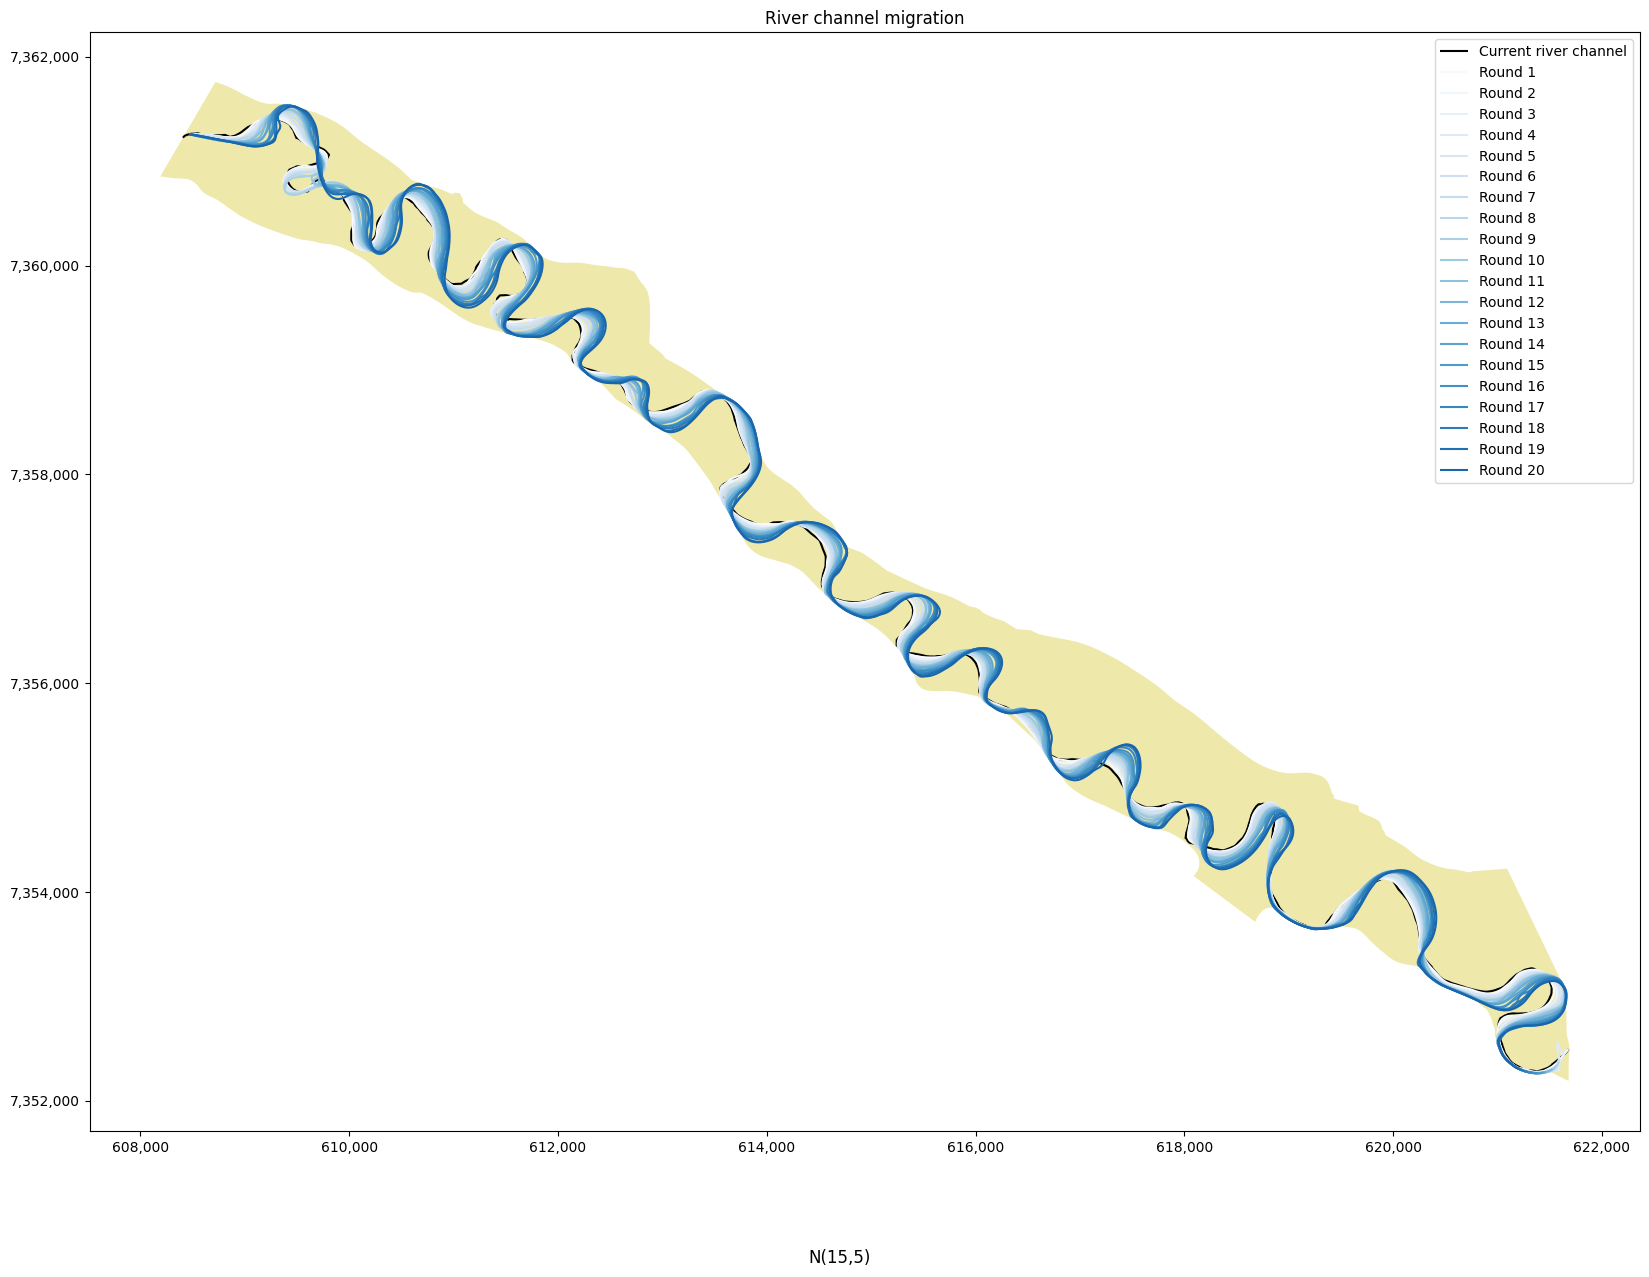

In [16]:
#ALGORITHM

import numpy as np
from shapely.geometry import Point

def reverse_migration_simulation(N_s, channel_path, mean_offset, std_dev_offset, cut_off_distance, feasible_region):
    new_points = {}
    spline = {}
    spline_gdf = {}
    oxbow_points = []

    for s in range(N_s):

        # Initialize a GeoDataFrame to store the new points
        new_points[s] = gpd.GeoDataFrame(columns=['geometry', 'curvature', 'meander'])

        # Inflection points of the current channel path
        inflection_points = define_inflectionpoints(channel_path['geometry'], 4)

        # Define meander bends
        define_meander(channel_path, inflection_points)
        # Add into new_points
        new_points[s]['meander'] = channel_path['meander']

        # Define top points
        top = define_top_points(inflection_points, channel_path)
        
        # Radius of circles which are defined by three consecutive points
        radius, interp, sol, A, B = radius_and_intersectionpoint(channel_path)

        # Curvature
        calculate_curvature(channel_path, radius)
        # Add into new_points
        new_points[s]['curvature'] = channel_path['curvature']
        
        # Define the Nhm number of half-meanders of the current channel path
        N_hm = len(inflection_points) - 1
        
        # Define the migration directions
        #D_direction, L_direction = define_directions(inflection_points) # 90

        D_direction, L_direction = define_directions_top(inflection_points, top) # huippu


        # Sample horizontal and lateral offsets from Gaussian distribution

        '''

        By changing these: 

        1.Pure lateral reverse migration : OD = 0 and OL ~ N(mean,sd), 

        2.Pure reverse downstream migration : OD ~ N(mean, sd) and  OL = 0, 

        3.Mixed reverse migration : OD ~ N(mean, sd) and OL ~ N(mean,sd), 
        

        Migration with accepting/not accepting negative offsets,
        can be modified in function called "offsets"
        
        '''
    
        OD = np.random.normal(mean_offset, std_dev_offset, N_hm)
        #OD = np.zeros(N_hm)

        OL = np.random.normal(mean_offset, std_dev_offset, N_hm)
        #OL = np.zeros(N_hm)

        # Sample smoothing values sL and sD from a uniform distribution
        
        max_OD = max(np.abs(OD))
        max_OL = max(np.abs(OL))

        min_sD = 0
        max_sD = 2 * max_OD

        min_sL = 0
        max_sL = 2 * max_OL

        sD = np.random.uniform(min_sD, max_sD, N_hm)  # zero if OD is zero
        sL = np.random.uniform(min_sL, max_sL, N_hm) # zero if OL is zero
                            
        # Sample the weighting w
        w = np.random.choice([-1, 1], N_hm) 

        # Initialize a list to store the new points
        newpoint_list = []
        
        for hm in range(N_hm): 
            
            # Filter points of one meander
            pm = (channel_path['meander'] == hm)
            filtered_pm = channel_path[pm]

            mig_D, mig_L = offsets(filtered_pm, OD[hm], OL[hm], sD[hm], sL[hm], w[hm])

            #Move points

            for pn in range(len(filtered_pm['geometry'])):

                new_point = (
                    filtered_pm['geometry'].iloc[pn].x + ((mig_D[pn] * D_direction[hm][0]) + (mig_L[pn] *   L_direction[hm][0])) ,
                    filtered_pm['geometry'].iloc[pn].y + ((mig_D[pn] * D_direction[hm][1]) + (mig_L[pn] *   L_direction[hm][1]))
                    )
                if not np.isnan(new_point).all():
                    newpoint = check_feasible_region(filtered_pm['geometry'].iloc[pn], new_point, feasible_region)
                    newpoint_list.append(newpoint)
                else:
                    newpoint = (filtered_pm['geometry'].iloc[pn].x ,  filtered_pm['geometry'].iloc[pn].y)
                    newpoint_list.append(Point(newpoint)) 
             
                
        # Add new points to the GeoDataFrame
        new_points[s]['geometry'] = newpoint_list

        # Check if new obxbow lakes will appear
        channel_path_deleted_oxbows, oxbows = new_oxbow(channel_path, inflection_points, cut_off_distance)


        # If there is new oxbows
        if len(oxbows) > 0: 
            # Initialize geodataframe again for new points
            new_points[s]=gpd.GeoDataFrame(columns=['geometry'])

            # Add points without oxbow bends
            new_points[s]['geometry'] = [Point((point.x, point.y)) for point in channel_path_deleted_oxbows['geometry']]

            oxbow_points.append(oxbows)

        # Spline
        spline[s], spline_gdf[s] = create_spline((new_points[s]['geometry']).apply(lambda point: (point.x, point.y)).tolist())

        # Update new path to next round
        channel_path = create_breakpoints(spline[s], 75)
        channel_path['geometry'] = channel_path['geometry'].iloc[::-1].values
        
    # Plot
    fig, ax = plt.subplots(figsize=(20, 15))

    def format_eastings(value, pos):
        return f'{int(value):,}'

    def format_northings(value, pos):
            return f'{int(value):,}'

    ax.xaxis.set_major_formatter(FuncFormatter(format_eastings))
    ax.yaxis.set_major_formatter(FuncFormatter(format_northings))

    feasible_region.plot(ax=ax, color = 'palegoldenrod')
    
    # Original channel_path
    centerline.plot(ax=ax, color='black', label='Current river channel')
    # Splines of rounds
    for i in range (len(new_points)):
        gradient = np.linspace(0, 1, len(new_points)+5)
        color = plt.cm.Blues(gradient[i])
        gpd.GeoDataFrame(geometry=[spline[i]]).plot(ax=ax, color=color, label=f'Round {i+1}')


    title_txt = "River channel migration"
    plt.title(title_txt)
    suptitle_text = f'N({mean_offset},{std_dev_offset})'
    plt.suptitle(suptitle_text, x=0.5, y=0.05, ha='center')
    plt.legend()
    plt.show()


'''

Input

N_s: Number of simulations.

channel_path: Current river channel.

mean_offset: Average D and L migration distance.
std_dev_offset: Standard deviation of D and L migration distances.

cut_off: Cut-off distance for oxbowlakes.
feasible_region: Feasible region for channel migration.

'''

N_s = 20

channel_path = points

mean_offset = 15
std_dev_offset = 5

cut_off = 150

feasible_region = feasible_region

reverse_migration_simulation(N_s, channel_path, mean_offset, std_dev_offset,  cut_off, feasible_region)
